# AP articles, LDA topics and views

In [1]:
import json
import pandas as pd
import numpy as np
from itertools import chain

topics_path = '/Users/Gui/Data/ap_topics_tags.json'
ap_topics_tags = json.load(open(topics_path))
flatten_topic_tags_weights = chain(*[[(topic['id'], tag, weight) for tag, weight in topic['topics'].items()] 
                              for topic in ap_topics_tags])

topics_word_weights = pd.DataFrame.from_records(flatten_topic_tags_weights, columns=['topic', 'word', 'weight'])
topics_word_weights.head()

,topic,word,weight
0,0,helt,0.000629
1,0,godt,0.000431
2,0,hele,0.000430
3,0,andre,0.000436
4,0,gang,0.000564


In [2]:
def topn_words(word_weights, topn=10):
    top_words = '/'.join(word_weights.sort_values('weight', ascending=False).iloc[:topn,:]['word'].values)
    return top_words

top_word_topics = topics_word_weights.groupby('topic').aggregate(topn_words)[['word']]

top_word_topics.head()

,word
topic,
0,klar/ny/følge/får/fem/mistet/under/tre/første/tok
1,kveld/søndag/fredag/mandag/lørdag/torsdag/meld...
2,forskning/Universitetet/studier/professor/fors...
3,klar/ny/følge/får/mistet/fem/under/tre/første/tok
4,Bulgaria/drakt/bunad/Dahl/skape/sy/stilt/John/...


In [3]:
# Very similar topics repeated
top_word_topics.groupby('word').size().sort_values(ascending=False).head(10)

word
klar/ny/følge/får/fem/mistet/under/tre/første/tok                      15
ny/klar/følge/får/fem/mistet/under/tre/første/tok                       7
ny/klar/får/følge/fem/mistet/under/tre/første/én                        3
klar/ny/følge/får/fem/under/mistet/første/tre/tok                       2
klar/ny/får/følge/fem/mistet/under/tre/første/én                        2
klar/ny/følge/får/fem/under/mistet/tre/første/tok                       2
klar/ny/følge/får/fem/mistet/under/tre/første/én                        2
åtte/vei/veltet/Heidi/Weng/fem/kalkuner/24/gikk/Vegetarfestival         1
far/gikk/april/mor/tyske/tyskerne/dag/måtte/soldater/fikk               1
fanget/Haram/Nigeria/leiren/Boko/rømte/mennesker/Mexico/ifølge/sier     1
dtype: int64

In [4]:
def ny_klar_topic(summary):
    return u'klar/ny' in summary or u'ny/klar' in summary

too_similar_topics = np.array(map(ny_klar_topic, top_word_topics.values[:,0]))
print(too_similar_topics.sum())

top_word_topics = top_word_topics.iloc[~too_similar_topics]
top_word_topics.groupby('word').size().sort_values(ascending=False).head(10)

36


word
åtte/vei/veltet/Heidi/Weng/fem/kalkuner/24/gikk/Vegetarfestival                    1
felt/Hauge/kontrakt/Ola/selskapet/Moe/oljeselskapene/bort/olje/Sverdrup            1
fanget/Haram/Nigeria/leiren/Boko/rømte/mennesker/Mexico/ifølge/sier                1
energi/utslipp/olje/gass/Oljefondet/kull/store/grønne/bruke/verden                 1
ei/frå/gjer/sjølv/berre/folk/fram/meir/kjem/dag                                    1
døde/drept/mennesker/ni/ofre/svarte/under/sa/byen/ifølge                           1
dyr/Mattilsynet/hest/stedet/mat/dårlig/NOAH/dyrevelferd/katter/stoff               1
drikke/litt/poeng/vin/glass/kr/smak/Karakter/alkohol/Røde                          1
direkte/Erik/Molde/Kristoff/Rosenborg/fulgte/Tour/deilig/Alexander/utlandet        1
debatten/Aftenposten/meninger/finne/Twitter/forstå/spørsmål/andre/Facebook/svar    1
dtype: int64

In [5]:
article_path = '/Users/Gui/Data/ap_article_topics_weights.json'
article_topics_weights = json.load(open(article_path))

flatten_article_weights = chain.from_iterable([[(int(article_id), topic_id, weight) for topic_id, weight in enumerate(features)] for article_id, features in article_topics_weights.items()])

article_weights = pd.DataFrame.from_records(flatten_article_weights, columns=['article_id', 'topic', 'weight'])

print(article_weights.dtypes)
print(article_weights.shape)
article_weights.head()

article_id      int64
topic           int64
weight        float64
dtype: object
(6769000, 3)


,article_id,topic,weight
0,8071297,0,0.004980
1,8071297,1,0.004986
2,8071297,2,0.004980
3,8071297,3,0.004980
4,8071297,4,0.004980


In [6]:
article_topic_weights = article_weights.pivot(index='article_id', columns='topic', values='weight')
article_topic_weights = article_topic_weights.ix[:, ~too_similar_topics]

article_topic_weights.columns = top_word_topics['word']
print(article_topic_weights.shape)

article_topic_weights.head()

(33845, 164)


word,kveld/søndag/fredag/mandag/lørdag/torsdag/melder/tirsdag/onsdag/NTB,forskning/Universitetet/studier/professor/forskere/effekt/forsker/forskerne/vitenskapelige/bruke,Bulgaria/drakt/bunad/Dahl/skape/sy/stilt/John/dress/plagg,Israel/israelske/palestinske/Palestina/palestinere/Jerusalem/ham/drept/konflikten/Vestbredden,kommentar/Marit/seiler/dag/Louis/Mette/Haakon/kronprinsen/monarkiet/kronprinsparets,lege/pasienter/behandling/sykehus/helse/psykisk/syke/medisiner/Høie/medisinsk,havnet/skip/Johnsen/signert/Karlsen/sier/boikott/tariffavtale/bruke/Yilport,skolen/elever/lære/lærere/fag/videregående/studenter/utdanning/klasse/får,gate/Ring/tunnelen/stenge/stengt/lang/trikken/sier/krysset/staten,Afghanistan/Taliban/Pakistan/afghanske/Larsen/sier/angrep/styrke/Kunduz/flere,...,jobber/leder/arbeidet/Nav/ansatte/prosjektet/stilling/lønn/få/personer,kjøpe/prostitusjon/sex/prostituerte/funksjonshemmede/rett/sexkjøpsloven/la/lov/selge,Oslo/restaurant/Hagen/parken/byen/mat/åpne/stedet/god/gjester,TV/NRK/serien/programmet/kanalen/NRKs/radio/2/episoden/Jaquesson,Lars/danske/Danmark/København/Løkke/Venstre/Rasmussen/Regjeringen/Thorning/Folkeparti,kaller/kalt/anbefalte/verneplikt/vraket/måneder/får/førstegangstjeneste/igjen/tre,ytringsfriheten/trusler/Frankrike/ytringer/Charlie/trussel/ytre/terror/rasisme/Hebdo,fikk/beskjed/fått/tok/dobbelt/statsborgerskap/satt/Steen/møte/første,avtalen/Iran/FN/USA/land/partene/enige/FNs/møte/forhandlingene,navn/heter/bytte/kjønn/skifte/mann/abort/etternavn/endre/født
article_id,,,,,,,,,,,,,,,,,,,,,
7078955,0.002691,0.004443,0.002304,0.107655,0.002825,0.002705,0.003169,0.002689,0.002728,0.003204,...,0.002948,0.002921,0.002993,0.004727,0.002660,0.003792,0.003700,0.002390,0.011229,0.002740
7410513,0.008259,0.004640,0.004004,0.003983,0.003876,0.004065,0.004410,0.003995,0.004330,0.004837,...,0.004556,0.006066,0.003808,0.003793,0.006879,0.003762,0.004142,0.003673,0.004392,0.004815
7495968,0.005279,0.004761,0.004529,0.004743,0.004552,0.004641,0.004722,0.004655,0.004746,0.004671,...,0.004583,0.004624,0.005321,0.004560,0.004816,0.004546,0.004604,0.004525,0.004601,0.004574
7693926,0.005361,0.005186,0.003163,0.003252,0.003158,0.003238,0.004630,0.003311,0.003307,0.004222,...,0.003522,0.002989,0.005025,0.003139,0.003299,0.003072,0.003210,0.003052,0.003604,0.002964
7696060,0.004363,0.003914,0.001875,0.002014,0.002210,0.002435,0.002069,0.002457,0.002154,0.002118,...,0.002476,0.002659,0.003219,0.008447,0.002080,0.001860,0.002204,0.001902,0.002722,0.002092


In [7]:
import sys
sys.path += ['/Users/gui/Dev/recs']
from recs import dataio

section_categories = [u'innenriks', u'verden', u'meninger', u'osloby', u'kultur', u'økonomi', u'sport inbox', u'digital inbox']

def first_section_found(categories):
    sections = filter(section_categories.__contains__, categories)
    return sections[0] if len(sections) else ''

article_categories = [(int(c['_id']), first_section_found(c['fields']['categories']), c['fields']['title'][0]) 
                      for c in dataio.load_article_content()]

article_categories = pd.DataFrame(article_categories, columns=['article_id', 'section', 'title']).set_index('article_id')
article_categories.head()

,section,title
article_id,,
7488609,osloby,Da er det over!
7492177,,Tegneserie - Zits 060314
7497336,,Instagram #apkaffe teaser
7506098,,Tegneserie - Zits 200314
7517785,,Zits 290314


# Loading AP user/article view events

In [8]:
events_file = "~/Data/collapsed_events_30_days.csv"
all_user_events = pd.read_csv(events_file, header=None, names=['ts', 'type', 'user', 'item'], parse_dates=['ts'])
all_user_events = all_user_events[all_user_events.item != "frontpage"]
all_user_events.item = all_user_events.item.astype('int64')

print("{} views from {} x {} user/articles from {} to {}".format(
        all_user_events.shape[0],
        all_user_events.user.unique().shape,
        all_user_events.item.unique().shape,
        all_user_events.ts.min(),
        all_user_events.ts.max()))

2305542 views from (138609,) x (38952,) user/articles from 2015-09-16 08:03:58 to 2015-10-15 23:59:36


In [9]:
events_with_article_content = all_user_events.item.isin(article_topic_weights.index)
user_events = all_user_events.ix[events_with_article_content.values, :]

print("{} events with content from {} x {} user/articles".format(
        user_events.shape[0],
        user_events.user.unique().shape,
        user_events.item.unique().shape))
user_events.head()

1665640 events with content from (113099,) x (8550,) user/articles


,ts,type,user,item
0,2015-09-30 17:04:52,View,3715244,8185208
2,2015-09-25 08:22:56,View,3532581,8179217
3,2015-10-07 18:56:51,View,3530156,8192364
4,2015-10-02 21:51:30,View,1751789,8182586
6,2015-10-08 06:01:03,View,3667067,8191776


In [10]:
# only some old articles seem missing
all_user_events[~events_with_article_content].groupby('item').agg({'item': len, 'ts':min}).sort_values('item', ascending=False).iloc[:10]

,item,ts
item,,
609106,10825,2015-09-28 08:31:37
611764,7080,2015-10-06 05:03:10
598679,7031,2015-09-24 08:17:55
613264,6133,2015-10-05 08:09:35
604826,5855,2015-09-21 09:57:32
601098,5842,2015-09-18 07:27:58
610013,5597,2015-09-29 12:20:02
610464,5360,2015-10-02 07:47:30
603415,5208,2015-09-18 21:07:00


# Joining article views and topics

In [11]:
user_events_with_topics = pd.merge(
    user_events,
    article_topic_weights.reset_index(),
    left_on='item',
    right_on='article_id')

print(user_events_with_topics.shape)
user_events_with_topics.head(5)

(1665640, 169)


,ts,type,user,item,article_id,kveld/søndag/fredag/mandag/lørdag/torsdag/melder/tirsdag/onsdag/NTB,forskning/Universitetet/studier/professor/forskere/effekt/forsker/forskerne/vitenskapelige/bruke,Bulgaria/drakt/bunad/Dahl/skape/sy/stilt/John/dress/plagg,Israel/israelske/palestinske/Palestina/palestinere/Jerusalem/ham/drept/konflikten/Vestbredden,kommentar/Marit/seiler/dag/Louis/Mette/Haakon/kronprinsen/monarkiet/kronprinsparets,...,jobber/leder/arbeidet/Nav/ansatte/prosjektet/stilling/lønn/få/personer,kjøpe/prostitusjon/sex/prostituerte/funksjonshemmede/rett/sexkjøpsloven/la/lov/selge,Oslo/restaurant/Hagen/parken/byen/mat/åpne/stedet/god/gjester,TV/NRK/serien/programmet/kanalen/NRKs/radio/2/episoden/Jaquesson,Lars/danske/Danmark/København/Løkke/Venstre/Rasmussen/Regjeringen/Thorning/Folkeparti,kaller/kalt/anbefalte/verneplikt/vraket/måneder/får/førstegangstjeneste/igjen/tre,ytringsfriheten/trusler/Frankrike/ytringer/Charlie/trussel/ytre/terror/rasisme/Hebdo,fikk/beskjed/fått/tok/dobbelt/statsborgerskap/satt/Steen/møte/første,avtalen/Iran/FN/USA/land/partene/enige/FNs/møte/forhandlingene,navn/heter/bytte/kjønn/skifte/mann/abort/etternavn/endre/født
0,2015-09-30 17:04:52,View,3715244,8185208,8185208,0.007684,0.001952,0.001554,0.001663,0.001659,...,0.001754,0.001976,0.001958,0.058983,0.00204,0.001513,0.001661,0.001537,0.001831,0.00173
1,2015-09-30 14:31:41,View,2643511,8185208,8185208,0.007684,0.001952,0.001554,0.001663,0.001659,...,0.001754,0.001976,0.001958,0.058983,0.00204,0.001513,0.001661,0.001537,0.001831,0.00173
2,2015-09-30 16:30:13,View,2447025,8185208,8185208,0.007684,0.001952,0.001554,0.001663,0.001659,...,0.001754,0.001976,0.001958,0.058983,0.00204,0.001513,0.001661,0.001537,0.001831,0.00173
3,2015-09-30 18:30:55,View,1119875,8185208,8185208,0.007684,0.001952,0.001554,0.001663,0.001659,...,0.001754,0.001976,0.001958,0.058983,0.00204,0.001513,0.001661,0.001537,0.001831,0.00173
4,2015-09-30 14:35:59,View,3296237,8185208,8185208,0.007684,0.001952,0.001554,0.001663,0.001659,...,0.001754,0.001976,0.001958,0.058983,0.00204,0.001513,0.001661,0.001537,0.001831,0.00173


## Views per topics

In [12]:
pd.DataFrame(user_events_with_topics.iloc[:, 5:].sum(), columns=['views']).sort_values('views', ascending=False).head(20)

,views
sier/mye/folk/gjør/litt/veldig/kommer/jo/tror/mer,37911.792890
livet/år/aldri/familien/gang/forteller/ham/dag/venner/snakke,25243.548404
må/gjør/få/mer/viktig/god/mulig/trenger/bedre/bør,24921.649839
Regjeringen/kutte/budsjettet/skatt/mer/år/økt/statsbudsjettet/bruke/neste,22653.111649
føler/D/innlegg/mennesker/gjør/andre/følge/dag/kroppen/Facebook,20845.280702
asylsøkere/sier/kommer/UDI/flyktninger/Norge/opphold/mottak/får/enslige,19387.505698
flyktninger/Europa/land/EU/migranter/grensen/mennesker/Middelhavet/kommer/Ungarn,19220.567422
politiet/mann/siktet/funnet/sier/pågrepet/saken/etterforskningen/avhør/ifølge,18613.330447
kommer/lenge/heller/problemer/store/langt/grunn/fortsetter/situasjonen/går,18496.767770
Oslo/byrådet/Johansen/Ap/sier/MDG/bystyret/byen/SV/Rødt,18386.870140


## User as mixture of topics

In [13]:
user_topics_sums = user_events_with_topics.groupby('user').sum().iloc[:, 5:]
user_article_counts = user_events_with_topics.groupby('user').size()
user_topics_probs = user_topics_sums.div(user_topics_sums.sum(axis=1), axis=0)

user_topics_probs.head()

,Israel/israelske/palestinske/Palestina/palestinere/Jerusalem/ham/drept/konflikten/Vestbredden,kommentar/Marit/seiler/dag/Louis/Mette/Haakon/kronprinsen/monarkiet/kronprinsparets,lege/pasienter/behandling/sykehus/helse/psykisk/syke/medisiner/Høie/medisinsk,havnet/skip/Johnsen/signert/Karlsen/sier/boikott/tariffavtale/bruke/Yilport,skolen/elever/lære/lærere/fag/videregående/studenter/utdanning/klasse/får,gate/Ring/tunnelen/stenge/stengt/lang/trikken/sier/krysset/staten,Afghanistan/Taliban/Pakistan/afghanske/Larsen/sier/angrep/styrke/Kunduz/flere,ben/knust/egg/fisk/Arendal/to/bort/første/Ålesund/siste,markere/protest/demonstrasjoner/under/Japan/Tyskland/demonstranter/Thailand/land/markering,Frp/Regjeringen/Solberg/partiet/sier/KrF/Jensen/Erna/ta/Stortinget,...,jobber/leder/arbeidet/Nav/ansatte/prosjektet/stilling/lønn/få/personer,kjøpe/prostitusjon/sex/prostituerte/funksjonshemmede/rett/sexkjøpsloven/la/lov/selge,Oslo/restaurant/Hagen/parken/byen/mat/åpne/stedet/god/gjester,TV/NRK/serien/programmet/kanalen/NRKs/radio/2/episoden/Jaquesson,Lars/danske/Danmark/København/Løkke/Venstre/Rasmussen/Regjeringen/Thorning/Folkeparti,kaller/kalt/anbefalte/verneplikt/vraket/måneder/får/førstegangstjeneste/igjen/tre,ytringsfriheten/trusler/Frankrike/ytringer/Charlie/trussel/ytre/terror/rasisme/Hebdo,fikk/beskjed/fått/tok/dobbelt/statsborgerskap/satt/Steen/møte/første,avtalen/Iran/FN/USA/land/partene/enige/FNs/møte/forhandlingene,navn/heter/bytte/kjønn/skifte/mann/abort/etternavn/endre/født
user,,,,,,,,,,,,,,,,,,,,,
100006,0.003400,0.250700,0.003222,0.003199,0.003167,0.003148,0.003055,0.003159,0.003193,0.003465,...,0.003350,0.003295,0.003135,0.002956,0.005687,0.002818,0.003582,0.005778,0.004900,0.002914
100013,0.002898,0.003202,0.019829,0.003187,0.030154,0.004598,0.003579,0.007863,0.003382,0.013896,...,0.007631,0.002966,0.003050,0.023917,0.003456,0.003313,0.003664,0.004105,0.006229,0.003690
100018,0.004135,0.003106,0.028444,0.002746,0.005271,0.003299,0.003136,0.003243,0.003894,0.004809,...,0.009213,0.003046,0.005304,0.005043,0.002964,0.002993,0.003708,0.004353,0.014681,0.003084
100027,0.003214,0.003493,0.003664,0.002802,0.003605,0.003689,0.002930,0.003706,0.003155,0.018457,...,0.005539,0.004284,0.003231,0.008757,0.003581,0.002898,0.003527,0.006705,0.007763,0.004605
100037,0.003987,0.003018,0.003146,0.002741,0.007433,0.004313,0.004761,0.006049,0.003821,0.003148,...,0.004360,0.036914,0.007446,0.004341,0.004713,0.003099,0.003242,0.004308,0.004125,0.002704


## Users topical space

,2d vector length
Regjeringen/kutte/budsjettet/skatt/mer/år/økt/statsbudsjettet/bruke/neste,0.796499
Russland/russiske/Putin/NATO/Ukraina/vest/krigen/land/president/øst,0.266852
IS/Syria/angrep/Tyrkia/drept/Irak/al/tyrkiske/sier/ifølge,0.151587
føler/D/innlegg/mennesker/gjør/andre/følge/dag/kroppen/Facebook,0.117210
flyktninger/Europa/land/EU/migranter/grensen/mennesker/Middelhavet/kommer/Ungarn,0.085558
asylsøkere/sier/kommer/UDI/flyktninger/Norge/opphold/mottak/får/enslige,0.064233
sier/mye/folk/gjør/litt/veldig/kommer/jo/tror/mer,0.048971
Oslo/byrådet/Johansen/Ap/sier/MDG/bystyret/byen/SV/Rødt,0.044969
livet/år/aldri/familien/gang/forteller/ham/dag/venner/snakke,0.039456
lege/pasienter/behandling/sykehus/helse/psykisk/syke/medisiner/Høie/medisinsk,0.032714


/Users/gui/.virtualenvs/gui/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


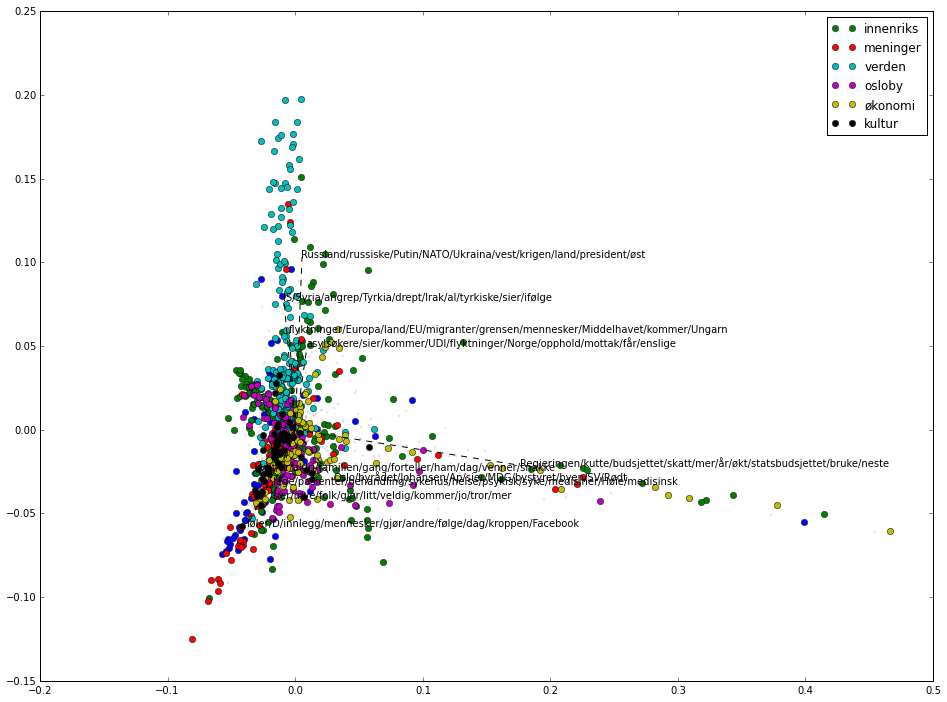

In [14]:
import numpy as np
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16, 12))

# users
pca = PCA(n_components=10)
pca.fit(user_topics_probs.values[user_article_counts.values > 5, :])
visible_user_mask = user_article_counts.values > 1
user_2d = pd.DataFrame(
    data=pca.transform(user_topics_probs.values[visible_user_mask, :]),
    index=user_topics_probs[visible_user_mask].index)

plt.plot(user_2d.values[:1000,0], user_2d.values[:1000,1], 'ko', markeredgecolor='grey', ms=2, alpha=.1)

# top 50 articles
top = 1000
article_counts = user_events_with_topics.groupby('item').size().sort_values(ascending=False)
top_articles = article_counts.iloc[:top].index
articles_pca_df = pd.DataFrame(
    data=pca.transform(article_topic_weights.ix[top_articles, user_topics_probs.columns]),
    index=top_articles).join(article_categories)

articles_pca_df.section[articles_pca_df.section == ''] == 'misc'

for key, indexes in articles_pca_df.reset_index().groupby('section').groups.items():
    plt.plot(articles_pca_df.values[indexes, 0], articles_pca_df.values[indexes, 1], 'o', label=key)

scatter = plt.scatter(articles_pca_df.values[:,0], articles_pca_df.values[:,1], s=50, alpha=0.01)

# topics arrow
base_topics = user_topics_probs.columns.tolist()
def topics_to_canonical_array(topics, base_topics=base_topics):
    return np.array([1 if t in topics else 0 for t in base_topics])

topics_2d = pd.DataFrame(
    data=np.array([pca.transform(topics_to_canonical_array([topic]))[0] for topic in base_topics]),
    index=base_topics)

n = 10
topn_topics = topics_2d.apply(
    lambda row: np.power(row[0], 2) + np.power(row[1], 2), axis=1).sort_values(ascending=False).iloc[:n]

arrow_length_ratio = .2
for topic in topn_topics.index:
    point = topics_2d.loc[topic].values * arrow_length_ratio
    if len(point.shape) > 1:
        point = point[0,:]
    plt.text(point[0], point[1], s=topic)
    #plt.arrow(0, 0, point[0], point[1], width=0.0001, length_includes_head=True, head_width=0.0025)
    plt.plot([0, point[0]], [0, point[1]], 'k--')

#plt.xlim([-0.2, 0.2]); plt.ylim([-0.2, 0.2])
plt.legend()

pd.DataFrame(topn_topics, columns=['2d vector length'])

In [15]:
ordered_topics = topics_2d.apply(lambda x: np.log(x + 1) / np.log(10)).iloc[np.argsort(-np.power(topics_2d.values, 2).sum(1))]

with open('../web/users_articles_topics.json', 'w+') as f:
    json.dump({
            'topics': ordered_topics.reset_index().rename(columns={'index':'words'}).rename(columns={i: str(i) for i in range(100)}).to_dict(orient='record'),
            'articles': articles_pca_df.iloc[:500,:].rename(columns={i: str(i) for i in range(100)}).to_dict(orient='record'),
            'users': user_2d.iloc[:1000,:].reset_index().rename(columns={'index':'id'}).rename(columns={i: str(i) for i in range(100)}).to_dict(orient='record')
            }
            ,f)

## PCA on the Article topic space

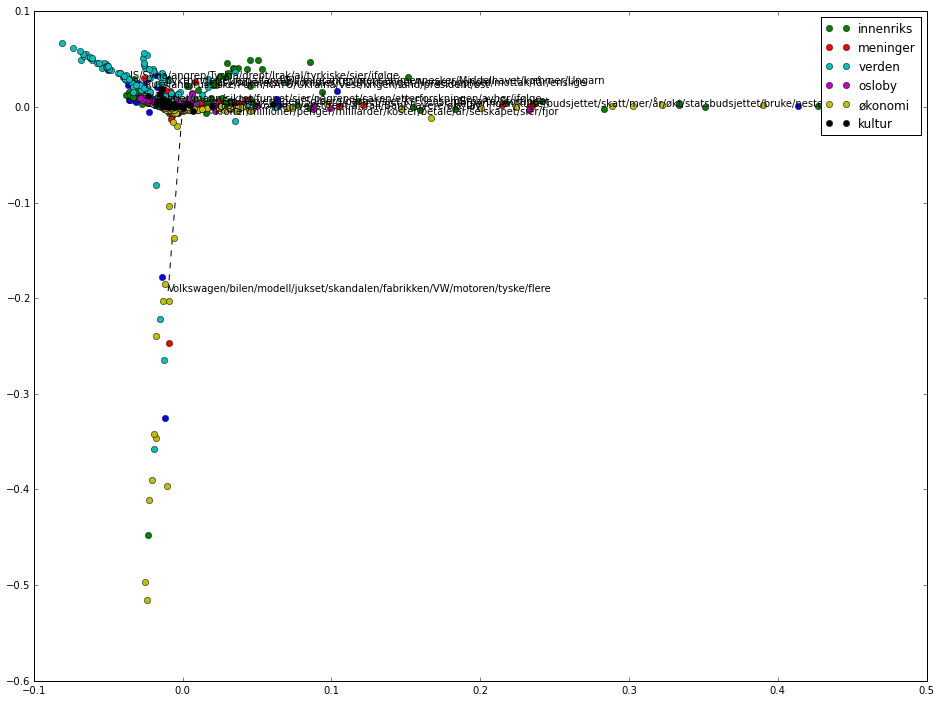

In [37]:
import numpy as np
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16, 12))

# articles
top = 1000
article_counts = user_events_with_topics.groupby('item').size().sort_values(ascending=False)
top_articles = article_counts.iloc[:top].index
pca = PCA(n_components=10)
pca.fit(article_topic_weights.ix[top_articles].values)

article_pcaed = pd.DataFrame(
    data=pca.transform(article_topic_weights.ix[top_articles].values),
    index=article_topic_weights.ix[top_articles].index)

# topics arrow
base_topics = article_topic_weights.columns.tolist()
def topics_to_canonical_array(topics, base_topics=base_topics):
    return np.array([1 if t in topics else 0 for t in base_topics])

topics_2d = pd.DataFrame(
    data=np.array([pca.transform(topics_to_canonical_array([topic]))[0] for topic in base_topics]),
    index=base_topics)

n = 10
topn_topics = topics_2d.apply(
    lambda row: np.power(row[0], 2) + np.power(row[1], 2), axis=1).sort_values(ascending=False).iloc[:n]

arrow_length_ratio = .2
for topic in topn_topics.index:
    point = topics_2d.loc[topic].values * arrow_length_ratio
    if len(point.shape) > 1:
        point = point[0,:]
    plt.text(point[0], point[1], s=topic)
    #plt.arrow(0, 0, point[0], point[1], width=0.0001, length_includes_head=True, head_width=0.0025)
    plt.plot([0, point[0]], [0, point[1]], 'k--')


articles_pca_df = article_pcaed.join(article_categories)
articles_pca_df.section[articles_pca_df.section == ''] == 'misc'

for key, indexes in articles_pca_df.reset_index().groupby('section').groups.items():
    plt.plot(articles_pca_df.values[indexes, 0], articles_pca_df.values[indexes, 1], 'o', label=key)

plt.legend();

In [48]:
ordered_topics = topics_2d.apply(lambda x: np.log(x + 1) / np.log(10)).iloc[np.argsort(-np.power(topics_2d.values, 2).sum(1))]

with open('../web/articles_topics.json', 'w+') as f:
    json.dump({
            'topics': ordered_topics.reset_index().rename(columns={'index':'words'}).rename(columns={i: str(i) for i in range(100)}).to_dict(orient='record'),
            'articles': articles_pca_df[~articles_pca_df.title.isnull()].rename(columns={i: str(i) for i in range(100)}).to_dict(orient='record'),
            'users': [{"1": -0.016293166792729973, "0": -0.011797258878539555, "3": 0.0012421671186793571, "2": -0.012754190567583909, "5": -0.0046697425459495297, "user": 100013.0, "7": 0.00092039311795600177, "6": 0.0061159259015461246, "9": 0.024472724141006357, "8": 0.013050953065599561, "4": 0.0020430792390022335}]
            }
            ,f)

999